In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import cv2
import os 

In [2]:
#Create a mask for beam block removal
def circl(x,y, xcen = 396, ycen = 390):
    """
    This functionchecks if a point defined by its x,y cordinates are inside or outside a 
    defined circle with center at xcen, ycen and radius rr
    
    """
    rr = mt.sqrt((x-xcen)**2+(y-ycen)**2)
    if rr>=45:  #rr<=350 and
        return True
    else:
        return False
    
def mask(img):
    """
    maask function applies the mask onto the image input
    
    """
    [x,y] = np.shape(img)
    mask = np.zeros([x,y])
    for i in range(x):
        for j in range(y):
            mask[i,j] = pointcheck(i,j)*circl(i,j)
    return mask

def pointcheck(xp,yp):
    """
    Point check creats a rectangle on top of the beam block manually and checks if the point is inside it or
    outside
    """
    x1,x2,x3,x4 = [400,400,0,0]
    y1,y2,y3,y4 = [345,400,400,345]
    d1 = (x1-x2)*(yp-y1)-(xp-x1)*(y2-y1)
    d2 = (x2-x3)*(yp-y2)-(xp-x2)*(y3-y2)
    d3 = (x4-x3)*(yp-y3)-(xp-x3)*(y4-y3)
    d4 = (x1-x4)*(yp-y4)-(xp-x4)*(y1-y4)
    if d1<0 and d2<0 and d3>0 and d4>0:
        return False
    else:
        return True

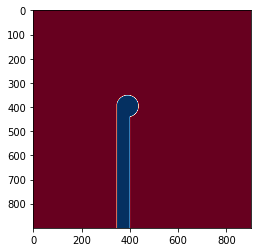

In [3]:
img = np.array(np.zeros([900,900]),dtype = 'uint8')
plt.imshow(mask(img), cmap = 'RdBu_r')

(900, 900)


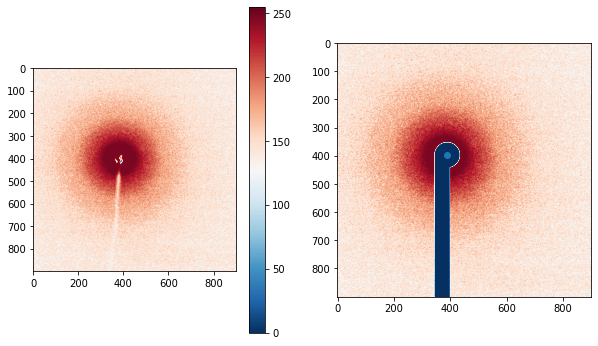

In [4]:
folder = r'D:\PhD Experimental data\Electron diffraction\Analysis\18-02-2020'
file =  '2020-02-18_306mW_10us.png'#'delay_4us.png'

diff_img = cv2.imread(os.path.join(folder,file),0)
print(diff_img.shape)
masked = np.multiply(diff_img, mask(diff_img))
xcen = 396; ycen = 390

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(diff_img, cmap = 'RdBu_r')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(masked, cmap = 'RdBu_r')
plt.scatter(390,396)

In [5]:
from diffraction_subfunctions import diffraction_to_azimuthal_avg

s_4us,I_tot = diffraction_to_azimuthal_avg(masked)

Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.886544e-02, 1.879440e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=391.550, y=393.030 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


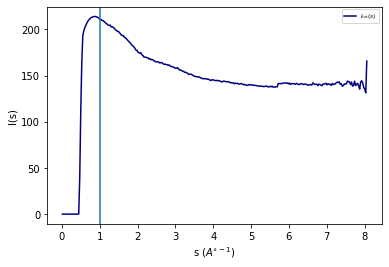

In [6]:
Itot_s2 = np.multiply(I_tot,(np.multiply(s_4us, s_4us)))
plt.plot(s_4us, I_tot, label = '$I_{tot}(s)$', color = 'navy')
#plt.plot(s_4us, Itot_s2, label = '$I_{tot}(s)$', color = 'brown')
plt.xlabel('s ($A^{\circ-1}$)')
plt.ylabel('I(s)')
plt.axvline(1.0)
plt.legend(fontsize = 'xx-small', loc=1)

Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.886544e-02, 1.879440e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=391.550, y=393.030 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


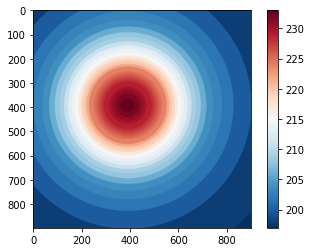

In [7]:
atomic_diff_file = os.path.join(os.getcwd(), 'Iatom_gly_simulated_kirk.png')
I_atom_gly = cv2.imread(atomic_diff_file,0)

_,I_atom = diffraction_to_azimuthal_avg(I_atom_gly)

plt.imshow(I_atom_gly, cmap = 'RdBu_r')
plt.colorbar()

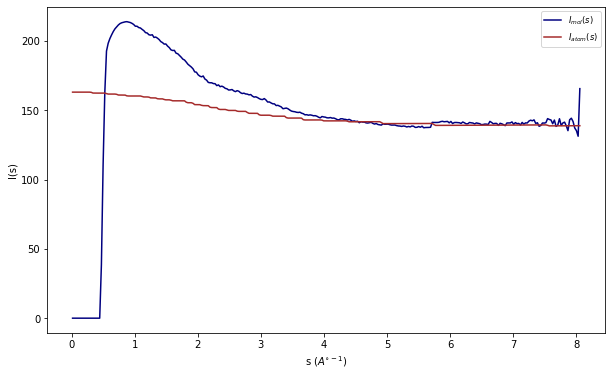

In [8]:
I_atom_new = np.multiply(I_atom,0.7)

plt.figure(figsize=(10, 6))
plt.plot(s_4us, I_tot, label = '$I_{mol}(s)$', color = 'navy')
plt.plot(s_4us, I_atom_new, label = '$I_{atom}(s)$', color = 'brown')
plt.xlabel('s ($A^{\circ-1}$)')
plt.ylabel('I(s)')
#plt.xlim([1,8])
plt.legend(fontsize = 'small', loc=1)#xx-small

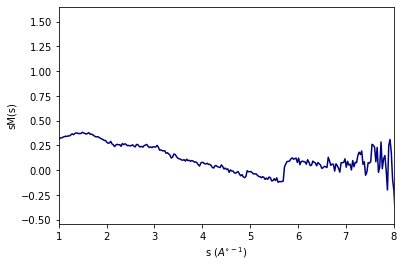

In [9]:
sMs_Itot_Ibg = np.multiply(s_4us, np.divide(I_tot-I_atom_new, I_atom_new))

plt.plot(s_4us, sMs_Itot_Ibg, color = 'navy')
plt.xlim([1,8])
plt.xlabel('s ($A^{\circ-1}$)')
plt.ylabel('sM(s)')
plt.savefig('sM(s)_ccl4.png', bbox_inches = 'tight')

In [10]:
def cut_array(sx,Itot):
    s_cut = []
    I_cut = []
    for s,I in zip(sx,Itot):
        if s>=1.0 and s<=8.0: #
            s_cut.append(s)
            I_cut.append(I)
        else:
            continue
    return s_cut, I_cut

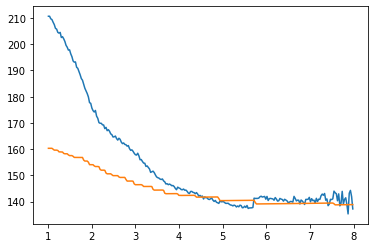

In [11]:
s_cut, I_cut = cut_array(s_4us, I_tot)
_, I_atom_cut = cut_array(s_4us, I_atom_new)
plt.plot(s_cut,I_cut)
plt.plot(s_cut,I_atom_cut)

In [12]:
#Background being subtracted after fitting the Itot to a cubic polynomial
from scipy.optimize import curve_fit
def fit_poly(x,a,b,c,d):
    x2 = np.multiply(x,x)
    x3 = np.multiply(x2,x)
    y = np.multiply(a, x3)+np.multiply(b, x2)+np.multiply(c,x)+d
    #y = a*x**3+b*x**2+c*x+d
    return y
popt, pcov = curve_fit(fit_poly, s_cut, I_cut)
print(popt)

[ -0.49668889   9.60623073 -60.74256677 265.80627463]


In [13]:
bg = fit_poly(s_cut, popt[0],  popt[1], popt[2], popt[3])

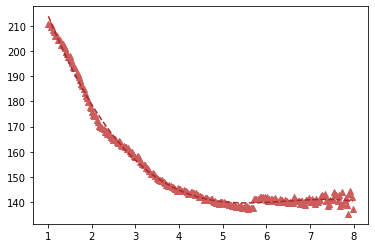

In [14]:
plt.scatter(s_cut, I_cut, marker = '^', color = 'indianred')
plt.plot(s_cut, bg, color = 'brown', ls = '--')

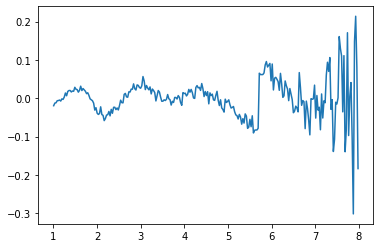

In [15]:
sMs = np.multiply(s_cut, np.divide(I_cut-bg, I_atom_cut))
#plt.scatter(s_cut, sMs, marker = '^', color = 'indianred')
plt.plot(s_cut, sMs)

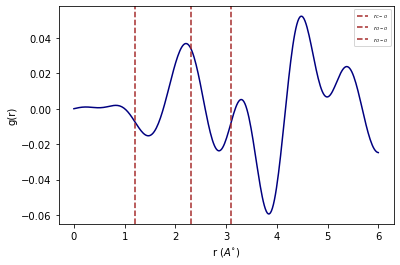

In [16]:
from diffraction_subfunctions import sms_to_mrdf

r, mrdf = sms_to_mrdf(s_cut, sMs)

plt.plot(r, mrdf,color = 'navy')
#plt.axvline(1.108, ls = '--', color = 'brown', label = '$r_{C-O}=1.1674 A^{\circ}$')
plt.axvline(1.2, ls = '--', color = 'brown', label = '$r_{C-O}$')
plt.axvline(2.3, ls = '--', color = 'brown', label = '$r_{O-O}$')
plt.axvline(3.1, ls = '--', color = 'brown', label = '$r_{O-O}$')
plt.xlabel('r ($A^{\circ}$)')
plt.ylabel('g(r)')
plt.legend(fontsize = 'xx-small', loc=1)

In [17]:
xyz_file_path = os.getcwd()
xyz_file_name ='Glycerol.xyz'
file = os.path.join(xyz_file_path,xyz_file_name)
from diffraction_subfunctions import diff_image_generator

Iatom_theory, Imol_theory = diff_image_generator(file) 